In [98]:
from math import *
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import cm
from scipy.interpolate import lagrange
from scipy.optimize import curve_fit
import re
from scipy.stats import boxcox, ttest_ind
from scipy.stats import rv_histogram
import scipy.stats as stats
from scipy.special import inv_boxcox
import statsmodels as sm
import sklearn as sk
from sklearn.preprocessing import power_transform
from multiprocessing import Pool
from mpl_toolkits.basemap import Basemap as Basemap
import mplleaflet

#network analysis packages
import networkx as nx
import community
from community import community_louvain
import leidenalg as ld
from networkx.algorithms.community import greedy_modularity_communities
import warnings
from matplotlib.collections import LineCollection

from datetime import datetime, timedelta
warnings.filterwarnings('ignore')
import difflib #for finding closest word match
import os

In [99]:
f = pd.read_csv('airports.dat.txt', header = None)
f = f.rename(columns = {0: 'ID', 1: 'Name', 2: 'City', 3: 'Country', 4: 'IATA', 5: 'ICAO', 6: 'Latitude', 7: 'Longitude',
         8: 'Altitude', 9: 'Timezone', 10: 'DST', 11: 'Tz Database Timzone', 12: 'Type', 13: 'Source'})
f = f[f['Country'] == 'United States']
f = f[['IATA', 'ICAO', 'Latitude', 'Longitude']]

def alphabetize_OD_pair(df):
    a = np.sort(np.array([df['OD'].str[0:3], df['OD'].str[3:6]]).T)
    a_df = pd.DataFrame(a)
    a_df = pd.Series(a_df[0] + a_df[1])
    df['OD'] = a_df
    return df

# 1. OD Pair and Passenger Analysis

If this section has already been run and saved, skip to **Section 2**.

In [7]:
intra_CA = pd.read_csv('Results/intra-CA-emissions.csv')
out_of_CA = pd.read_csv('Results/out-of-CA-emissions.csv')


In [8]:
carrier_name_icao = {'Southwest Airlines Co.': 'SWA', 'JetBlue Airways': 'JBU', 'SkyWest Airlines Inc.': 'SKW',
                     'Compass Airlines': 'CPZ', 'American Airlines Inc.': 'AAL', 'Alaska Airlines Inc.': 'ASA',
                     'Delta Air Lines Inc.': 'DAL', 'United Air Lines Inc.': 'UAL', 'Mesa Airlines Inc.': 'ASH',
                     'Horizon Air': 'QXE', 'Allegiant Air': 'AAY', 'Envoy Air': 'ENY', 
                     'Sun Country Airlines d/b/a MN Airlines': 'SCX',
                     'Frontier Airlines Inc.': 'FFT', 'Spirit Air Lines': 'NKS', 'Trans States Airlines': 'LOF', 
                     'Hawaiian Airlines Inc.': 'HAL', 'GoJet Airlines LLC d/b/a United Express': 'GJS', 
                     'ExpressJet Airlines LLC': 'ASQ', 'Atlas Air Inc.': 'GTI', 'Boutique Air': 'BTQ', 
                     'Contour Airlines': 'VTE', 'Ryan Air f/k/a Arctic Transportation': 'RYA', 
                     'Grand Canyon Airlines, Inc. d/b/a Grand Canyon Airlines d/b/a Scenic Airlines': 'SCE',
                     'Delux Public Charter LLC': 'JSX', 
                     'Hillwood Airways, LLC  f/k/a   ATX Air Services, LLC': 'HWA',
                     'Via Airlines d/b/a Charter Air Transport': 'SRY', 'KaiserAir, Inc.':'KAI',
                     'Ameristar Air Cargo': 'AJI', 'Swift Air, LLC d/b/a Eastern Air Lines d/b/a Eastern':'SWQ',
                     'Caribbean Sun Airlines, Inc. d/b/a World Atlantic Airlines': 'WAL', 
                     'Miami Air International':'BSK', 
                     'National Air Cargo Group Inc d/ba National Airlines': 'NCR',
                     'Eastern Airlines f/k/a Dynamic Airways, LLC':'EAL', 'Omni Air International LLC': 'OAE',
                     'Republic Airline':'RPA', 'Mokulele Flight Services, Inc.':'FDY'}

aircraft_name_icao = {'Boeing 737-700/700LR/Max 7': 'B737', 'Airbus Industrie A320-100/200': 'A320',
                      'Embraer ERJ-175': 'E170', 'Canadair RJ-200ER /RJ-440': 'CRJ2', 'Boeing 737-800': 'B738',
                      'Boeing B737 Max 800': 'B738', 'Airbus Industrie A321/Lr': 'A321', 
                      'Airbus Industrie A319': 'A319',
                      'Canadair RJ-700': 'CRJ7', 'Boeing 737-900ER': 'B739', 'Boeing 767-300/300ER': 'B763', 
                      'McDonnell Douglas DC9 Super 80/MD81/82/83/88': 'MD81', 'Embraer-140': 'E135', 
                      'B787-900 Dreamliner': 'B789', 'Boeing 777-300/300ER/333ER': 'B773',
                      'Boeing 777-200ER/200LR/233LR': 'B772',
                      'Airbus Industrie A330-300': 'A333', 'Boeing 787-10 Dreamliner': 'B78X', 
                      'Boeing 737-900': 'B739',
                      'Boeing 757-200': 'B752', 'Boeing 757-300': 'B753', 'Boeing 767-400/ER': 'B764', 
                      'Airbus Industrie A320-200n': 'A20N', 'Airbus Industrie A350-900': 'A359', 
                      'Airbus Industrie A321-200n': 'A21N', 'Boeing B737 Max 900': 'B37M', 
                      'Canadair CRJ 900': 'CRJ9',
                      'De Havilland DHC8-400 Dash-8': 'DH8D', 'Boeing 717-200': 'B712', 
                      'Airbus Industrie A330-200': 'A332',
                      'Embraer-145': 'E145', 'A200-100 BD-500-1A10': 'BCS1', 
                      'B787-800 Dreamliner': 'B788', 'Boeing 747-400': 'B747', 'Pilatus PC-12': 'PC12',
                      'Cessna 208 Caravan': 'C208', 'De Havilland Twin Otter DHC-6': 'DHC6',
                      'Embraer-135': 'E135', 'Boeing 737-500': 'B735', 'Boeing 737-100/200': 'B732',
                      'Boeing 767-200/ER/EM': 'B762', 'Boeing 737-300': 'B733', 'Boeing 737-400': 'B734'}

In [9]:
def rename_columns(df):
    rename_dict = {'OD': 'OD Pair Name', 'MONTH': 'Month', 'UNIQUE_CARRIER_NAME': 'Carrier', 
                        'Aircraft_Name': 'AircraftType', 'Average of Pax_per_Dep': 'Pax'}
    columns = list(df)
    new_df = pd.DataFrame()
    for col in columns:
        new_df[rename_dict[col]] = df[col]
    return new_df

In [10]:
pax_per_flight_L1 = pd.read_csv('pax_per_flight_2019_level1.csv')
pax_per_flight_L2 = pd.read_csv('pax_per_flight_2019_level2.csv')
pax_per_flight_L3 = pd.read_csv('pax_per_flight_2019_level3.csv')
pax_per_flight_L4 = pd.read_csv('pax_per_flight_2019_level4.csv')

pax_per_flight_L1['UNIQUE_CARRIER_NAME'] = pax_per_flight_L1['UNIQUE_CARRIER_NAME'].map(carrier_name_icao)
pax_per_flight_L1['Aircraft_Name'] = pax_per_flight_L1['Aircraft_Name'].map(aircraft_name_icao)

pax_per_flight_L2['UNIQUE_CARRIER_NAME'] = pax_per_flight_L2['UNIQUE_CARRIER_NAME'].map(carrier_name_icao)

#no mapping necessary for passenger data level3 or level4

pax_per_flight_L1 = alphabetize_OD_pair(pax_per_flight_L1) 
pax_per_flight_L2 = alphabetize_OD_pair(pax_per_flight_L2)
pax_per_flight_L3 = alphabetize_OD_pair(pax_per_flight_L3)
pax_per_flight_L4 = alphabetize_OD_pair(pax_per_flight_L4)

pax_per_flight_L1 = pax_per_flight_L1.groupby(['OD', 'MONTH', 'UNIQUE_CARRIER_NAME', 'Aircraft_Name']).mean().reset_index(level = [0, 1, 2, 3])
pax_per_flight_L2 = pax_per_flight_L2.groupby(['OD', 'MONTH','UNIQUE_CARRIER_NAME']).mean().reset_index(level = [0, 1, 2])
pax_per_flight_L3 = pax_per_flight_L3.groupby(['OD', 'MONTH']).mean().reset_index(level = [0, 1])
pax_per_flight_L4 = pax_per_flight_L4.groupby('OD').mean().reset_index(level = 0)

pax_per_flight_L1 = rename_columns(pax_per_flight_L1)
pax_per_flight_L2 = rename_columns(pax_per_flight_L2)
pax_per_flight_L3 = rename_columns(pax_per_flight_L3)
pax_per_flight_L4 = rename_columns(pax_per_flight_L4)

In [11]:
CA_flight_network = pd.concat([intra_CA, out_of_CA], axis = 0).reset_index().drop(['index'], axis = 1)
CA_flight_network['Distance (mi)'] = CA_flight_network['Distance (NM)'] * 1.15078
CA_flight_network = CA_flight_network.drop(['Distance (NM)'], axis = 1)
CA_flight_network_merge = CA_flight_network[['OD Pair Name', 'AircraftType', 'Carrier']]
CA_flight_network_merge['Month'] = CA_flight_network['ScheduledDepartureDate'].str[0:2].astype(int)
CA_flight_network_merge['Index'] = CA_flight_network_merge.index

#first-level merge (M1) (on OD pair, month, carrier, icao aircraft designator type)
CA_flight_network_M1 = CA_flight_network_merge.merge(pax_per_flight_L1, how = 'left',
                                on = ['OD Pair Name', 'AircraftType', 'Carrier', 'Month'])

passenger_data = CA_flight_network_M1[(~CA_flight_network_M1['Pax'].isnull()) & (CA_flight_network_M1['Pax'] != 0)]

CA_flight_network_M1 = CA_flight_network_M1[~CA_flight_network_M1['Index'].isin(passenger_data['Index'])].dropna(axis = 1)
CA_flight_network_M1 = CA_flight_network_M1.drop(['AircraftType'], axis = 1)

#pax_per_flight_L2 = pax_per_flight_L1.groupby(['OD Pair Name', 'Carrier', 'Month']).mean().reset_index(level = [0, 1, 2])

#second-level merge (on OD Pair, month, carrier)
CA_flight_network_M2 = CA_flight_network_M1.merge(pax_per_flight_L2, how = 'left', 
                                                  on = ['OD Pair Name', 'Carrier', 'Month'])

passenger_data = pd.concat([passenger_data, 
                            CA_flight_network_M2[(~CA_flight_network_M2['Pax'].isnull()) & (CA_flight_network_M2['Pax'] != 0)]],
                            axis = 0)

CA_flight_network_M2 = CA_flight_network_M2[~CA_flight_network_M2['Index'].isin(passenger_data['Index'])].dropna(axis = 1)
CA_flight_network_M2 = CA_flight_network_M2.drop(['Carrier'], axis = 1)

#pax_per_flight_L3 = pax_per_flight_L2.groupby(['OD Pair Name', 'Carrier']).mean().reset_index(level = [0, 1])

# #third-level merge (on OD Pair, month)
CA_flight_network_M3 = CA_flight_network_M2.merge(pax_per_flight_L3, how = 'left', 
                                                  on = ['OD Pair Name', 'Month'])

passenger_data = pd.concat([passenger_data, 
                            CA_flight_network_M3[(~CA_flight_network_M3['Pax'].isnull()) & (CA_flight_network_M3['Pax'] != 0)]],
                            axis = 0)

CA_flight_network_M3 = CA_flight_network_M3[~CA_flight_network_M3['Index'].isin(passenger_data['Index'])].dropna(axis = 1)
CA_flight_network_M3 = CA_flight_network_M3.drop(['Month'], axis = 1)

#pax_per_flight_L4 = pax_per_flight_L3.groupby('OD Pair Name').mean().reset_index(level = 0)

#fourth-level merge
CA_flight_network_M4 = CA_flight_network_M3.merge(pax_per_flight_L4, how = 'left',
                                                 on = 'OD Pair Name')

passenger_data = pd.concat([passenger_data, 
                            CA_flight_network_M4[(~CA_flight_network_M4['Pax'].isnull()) & (CA_flight_network_M4['Pax'] != 0)]],
                            axis = 0)

CA_flight_network_M4 = CA_flight_network_M4[~CA_flight_network_M4['Index'].isin(passenger_data['Index'])].dropna(axis = 1)


passenger_data = passenger_data.set_index('Index')[['Pax']]
CA_flight_network = CA_flight_network.merge(passenger_data, how = 'left', left_index = True, right_index = True)

#CA_flight_network = CA_flight_network[~CA_flight_network['Pax'].isnull()]

In [12]:
#second round of merges and subsitutions
matched = CA_flight_network[~CA_flight_network['Pax'].isnull()]
matched_grouped = matched.groupby(['AircraftType', 'Carrier']).mean().reset_index(level = [0,1])

unmatched = CA_flight_network[CA_flight_network['Pax'].isnull()].dropna(axis = 1)
unmatched['Index'] = unmatched.index
unmatched = unmatched.merge(matched_grouped, how = 'left', on = ['AircraftType', 'Carrier'])[['Index', 'Pax', 'Carrier', 'AircraftType']]

matched_unmatched = unmatched[~unmatched['Pax'].isnull()]
matched_unmatched = matched_unmatched.groupby('Index').mean().reset_index()
still_unmatched = unmatched[unmatched['Pax'].isnull()].dropna(axis = 1)

finally_matched = still_unmatched.merge(matched.groupby('AircraftType').mean()[['Pax']], how = 'left', left_on = 'AircraftType',
                      right_index = True)
finally_matched = finally_matched.groupby('Index').mean()[['Pax']].reset_index()

second_round_match = pd.concat([matched_unmatched, finally_matched]).set_index('Index')

second_round_match_2 = CA_flight_network[CA_flight_network['Pax'].isnull()].dropna(axis = 1).merge(second_round_match, left_index = True,
                                                           right_index = True)


In [13]:
CA_flight_network = pd.concat([matched, second_round_match_2]).sort_index()

In [14]:
#charter vs mainline airlines were classified using a variety of sources, most often: 
#https://www.avcodes.co.uk/airlcodesearch.asp
jet_ac = {'BD700': 13, 'C680': 8, 'C750': 8, 'G500': 13, 'C550': 10, 'G400': 12, 'CL600': 9, 
          'FA7X': 12, 'G200': 9, 'G650': 18, 'BE400': 8, 'C501': 6, 'C208': 9}

cargo_icao_codes = ['AJI', 'NCR', 'ABX', 'VTS', 'TSU', 'MGE', 'KII', 'JUS', 'LYC', 'KYE', 'PAC', 'WAL', 'SOO',
                   'UPS', 'WGN', 'CKS', 'FDX', 'ATN', 'RYA']

charter_jet_icao_code = ['VTE', 'JSX', 'WSN', 'BTQ', 'FDY', 'KAI', 'BSK', 'SIS', 'GTI', 'OAE', 'SWQ', 
                         'RPA', 'FZE', 'EAL', 'NCR', 'SCE', 'HWA', 'SRY', 'JML', 'RPM', 'GPD']

In [15]:
CA_flight_network = CA_flight_network[~CA_flight_network['Carrier'].isin(charter_jet_icao_code)]
replace_indices = CA_flight_network[CA_flight_network['AircraftType'].isin(jet_ac.keys())].index
charter_jet_mapping = CA_flight_network.loc[replace_indices, 'AircraftType'].map(jet_ac)
CA_flight_network.loc[replace_indices, 'Pax'] = charter_jet_mapping



In [16]:
CA_flight_network.to_csv('Save Points/4/CA_flights_passengers.csv', index = False)

# 2. Preparation for Data Analysis and Visualization

If this section has already been run (and saved), skip to section 3. 

In [17]:
CA_flight_network = pd.read_csv('Save Points/4/CA_flights_passengers.csv')

#calculate and add true distance column
distance_ratios = pd.read_csv('Save Points/2/frac_in_CA.csv').rename(columns = {'Unnamed: 0': 'OD Pair Name'}).set_index('OD Pair Name').to_dict()['Frac in CA']
frac_in_CA = CA_flight_network['OD Pair Name'].map(distance_ratios)
frac_in_CA[frac_in_CA.isnull()] = 1
true_dist = CA_flight_network['Distance (mi)'] / frac_in_CA
CA_flight_network['True Dist (mi)'] = true_dist

In [18]:
aircraft_by_route = CA_flight_network.groupby('OD Pair Name')['AircraftType'].apply(list)
common_ac = aircraft_by_route.apply(lambda ll: max(set(ll), key = ll.count))

In [19]:
CA_flight_network = CA_flight_network.reset_index()

In [20]:
#save distances in dictionary
distance_mapping = CA_flight_network.set_index('OD Pair Name')[['Distance (mi)']].to_dict()['Distance (mi)']
true_dist_mapping = CA_flight_network.set_index('OD Pair Name')[['True Dist (mi)']].to_dict()['True Dist (mi)']

CA_flight_network = CA_flight_network[['OD Pair Name', 'Departure', 'Arrival', 'Cruise Time (min)', 'Total Taxi/Idle (min)', 'Fuel Consumption (kg)', 'CO2 (kg)', 'HC (kg)', 'CO (kg)', 'NOx (kg)', 'NOx Dep Airport (kg)', 'NOx Arr Airport (kg)', 'PM (kg)', 'PM Dep Airport (kg)', 'PM Arr Airport (kg)', 'Pax']]
groupings = CA_flight_network.groupby(['OD Pair Name', 'Departure', 'Arrival']).size()
CA_flight_network = CA_flight_network.groupby(['OD Pair Name', 'Departure', 'Arrival']).sum()
CA_flight_network = pd.concat([groupings.rename('Num. of Flights'), CA_flight_network], axis = 1)
CA_flight_network = CA_flight_network.reset_index(level = [1,2])

CA_flight_network['Distance (mi)'] = CA_flight_network.index.map(distance_mapping, na_action = 'ignore')
CA_flight_network['True Dist (mi)'] = CA_flight_network.index.map(true_dist_mapping, na_action = 'ignore')

CA_flight_network['Cruise Time (min)'] /= CA_flight_network['Num. of Flights']
CA_flight_network['Total Taxi/Idle (min)'] /= CA_flight_network['Num. of Flights']
CA_flight_network['Pax'] = CA_flight_network['Pax'] / CA_flight_network['Num. of Flights']

In [21]:
CA_flight_network.loc['ACVSFO']

,Departure,Arrival,Num. of Flights,Cruise Time (min),Total Taxi/Idle (min),Fuel Consumption (kg),CO2 (kg),HC (kg),CO (kg),NOx (kg),NOx Dep Airport (kg),NOx Arr Airport (kg),PM (kg),PM Dep Airport (kg),PM Arr Airport (kg),Pax,Distance (mi),True Dist (mi)
OD Pair Name,,,,,,,,,,,,,,,,,,
ACVSFO,ACV,SFO,2290,41.261572,20.302620,4.417327e+06,1.392233e+07,1937.028456,25418.375770,39478.607956,5332.650010,2019.934932,443.623712,29.599203,3.495606,45.974803,249.657803,249.657803
ACVSFO,SFO,ACV,2294,39.168875,29.882738,4.354535e+06,1.372583e+07,2394.842560,30454.065006,37817.175776,5809.136938,1746.298512,430.250499,36.393678,3.415303,46.016966,249.657803,249.657803


In [22]:
def scale_emissions(df, metric):
    df_scaled = df.copy()
    for cc in list(df)[5:-3]:
        if metric == '/mi':
            df_scaled[cc] = df[cc] / (df['Num. of Flights'] * df['Distance (mi)'])
        elif metric == '/pax':
            df_scaled[cc] = df[cc] / df['Pax']
        elif metric == '/pax/mi':
            df_scaled[cc] = df[cc] / (df['Num. of Flights'] * df['Distance (mi)']) / df['Pax']
        elif metric == '/flight':
            df_scaled[cc] = df[cc] / df['Num. of Flights']
        elif metric == '/flight/pax':
            df_scaled[cc] = df[cc] / (df['Num. of Flights'] * df['Pax'])
        df_scaled = df_scaled.rename(columns = {cc: cc[0:-1] + metric + ')'})
    return df_scaled

In [23]:
CA_flight_network_scaled = scale_emissions(CA_flight_network, '/pax/mi').reset_index(level = 0)


In [24]:
CA_flight_network_scaled

,OD Pair Name,Departure,Arrival,Num. of Flights,Cruise Time (min),Total Taxi/Idle (min),Fuel Consumption (kg/pax/mi),CO2 (kg/pax/mi),HC (kg/pax/mi),CO (kg/pax/mi),NOx (kg/pax/mi),NOx Dep Airport (kg/pax/mi),NOx Arr Airport (kg/pax/mi),PM (kg/pax/mi),PM Dep Airport (kg/pax/mi),PM Arr Airport (kg/pax/mi),Pax,Distance (mi),True Dist (mi)
0,ABEBUR,ABE,BUR,1,311.100000,10.500000,0.458902,1.446106,0.000047,0.002891,0.002847,0.001676,0.000278,0.000053,1.371083e-06,9.603282e-08,12.000000,209.933860,2377.888912
1,ABEBUR,BUR,ABE,1,254.100000,12.500000,0.471200,1.485705,0.000080,0.003348,0.003769,0.001676,0.000306,0.000044,1.371083e-06,1.075076e-07,12.000000,209.933860,2377.888912
2,ABELAX,ABE,LAX,2,323.600000,29.000000,0.515065,1.623300,0.000153,0.003164,0.003218,0.001324,0.000355,0.000069,5.688098e-06,7.449869e-07,10.500000,221.033632,2387.643456
3,ABEOAK,ABE,OAK,1,314.100000,17.500000,0.571915,1.802335,0.000044,0.002296,0.005616,0.002736,0.000666,0.000296,2.107303e-06,3.904561e-07,13.000000,197.324710,2489.902951
4,ABEONT,ONT,ABE,351,252.054416,14.987179,0.157648,0.497095,0.000129,0.000630,0.003021,0.001431,0.000217,0.000016,1.255341e-06,5.975433e-08,151.773323,177.087115,2342.115426
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6172,VNYYIP,VNY,YIP,1,204.100000,17.500000,0.485982,1.532482,0.000110,0.003896,0.003829,0.001735,0.000320,0.000043,1.396629e-06,1.134559e-07,12.000000,209.543543,1965.718709
6173,VNYYIP,YIP,VNY,5,257.700000,19.900000,0.492452,1.551823,0.000096,0.002291,0.003577,0.001507,0.000351,0.000089,4.413257e-06,4.481151e-07,11.000000,209.543543,1965.718709
6174,VNYYKM,VNY,YKM,1,101.100000,16.500000,0.657144,2.071244,0.000061,0.002639,0.007865,0.001952,0.000436,0.000156,1.501155e-06,2.532297e-07,13.000000,274.746999,859.489032
6175,VNYYUM,VNY,YUM,1,38.100000,15.500000,0.706989,2.228014,0.000261,0.005748,0.011316,0.001156,0.000312,0.000046,2.788842e-07,5.118881e-09,8.000000,239.128084,248.625835


In [25]:
def lat_lon_merge(airport_df, loc_df):
    #merge on departures
    dep_merge = airport_df.merge(loc_df, left_on = 'Departure', right_on = 'IATA', how = 'left')
    dep_merge = dep_merge.drop(['IATA', 'ICAO'], axis = 1)
    dep_merge = dep_merge.rename(columns = {'Latitude': 'Dep Lat', 'Longitude': 'Dep Lon'})

    #merge on arrivals
    arr_merge = dep_merge.merge(loc_df, left_on = 'Arrival', right_on = 'IATA', how = 'left')
    arr_merge = arr_merge.drop(['IATA', 'ICAO'], axis = 1)
    arr_merge = arr_merge.rename(columns = {'Latitude': 'Arr Lat', 'Longitude': 'Arr Lon'})
    return arr_merge

In [26]:
CA_flight_network_scaled_loc = lat_lon_merge(CA_flight_network_scaled, f)
CA_flight_network_scaled_loc['Route Type'] = ['Domestic Out-of-CA'] * len(CA_flight_network_scaled_loc)
ca_iata_codes = list(pd.read_csv('CA Geographical Data/CA_airports.csv')['AIRPORTID'])
intra_CA = CA_flight_network_scaled_loc[CA_flight_network_scaled_loc.Departure.isin(ca_iata_codes)]
intra_CA = intra_CA[intra_CA.Arrival.isin(ca_iata_codes)]
CA_flight_network_scaled_loc.loc[intra_CA.index, 'Route Type'] = 'Intra-CA'

In [27]:
CA_flight_network_scaled_loc = CA_flight_network_scaled_loc.set_index('OD Pair Name')
CA_flight_network_scaled_loc['Common A/C Type'] = CA_flight_network_scaled_loc.index.map(common_ac)

In [28]:
CA_flight_network_scaled_loc.to_csv('Save Points/5/CA_flight_network_scaled.csv')

# 3. Calculating Distribution Statistics

**Start running code here**.

In [100]:
CA_flight_network_scaled_loc = pd.read_csv('Save Points/5/CA_flight_network_scaled.csv')

df_stats = CA_flight_network_scaled_loc.reset_index().groupby('OD Pair Name').mean()[['Fuel Consumption (kg/pax/mi)',
                                                                                    'CO2 (kg/pax/mi)',
                                                                                    'HC (kg/pax/mi)',
                                                                                    'CO (kg/pax/mi)',
                                                                                    'NOx (kg/pax/mi)',
                                                                                    'PM (kg/pax/mi)']]

In [101]:
CA_flight_network_scaled_loc = CA_flight_network_scaled_loc.set_index('OD Pair Name')

In [102]:
CA_flight_network_scaled_loc

,Departure,Arrival,Num. of Flights,Cruise Time (min),Total Taxi/Idle (min),Fuel Consumption (kg/pax/mi),CO2 (kg/pax/mi),HC (kg/pax/mi),CO (kg/pax/mi),NOx (kg/pax/mi),...,PM Arr Airport (kg/pax/mi),Pax,Distance (mi),True Dist (mi),Dep Lat,Dep Lon,Arr Lat,Arr Lon,Route Type,Common A/C Type
OD Pair Name,,,,,,,,,,,,,,,,,,,,,
ABEBUR,ABE,BUR,1,311.100000,10.500000,0.458902,1.446106,0.000047,0.002891,0.002847,...,9.603282e-08,12.000000,209.933860,2377.888912,40.652100,-75.440804,34.200699,-118.359001,Domestic Out-of-CA,G400
ABEBUR,BUR,ABE,1,254.100000,12.500000,0.471200,1.485705,0.000080,0.003348,0.003769,...,1.075076e-07,12.000000,209.933860,2377.888912,34.200699,-118.359001,40.652100,-75.440804,Domestic Out-of-CA,G400
ABELAX,ABE,LAX,2,323.600000,29.000000,0.515065,1.623300,0.000153,0.003164,0.003218,...,7.449869e-07,10.500000,221.033632,2387.643456,40.652100,-75.440804,33.942501,-118.407997,Domestic Out-of-CA,G400
ABEOAK,ABE,OAK,1,314.100000,17.500000,0.571915,1.802335,0.000044,0.002296,0.005616,...,3.904561e-07,13.000000,197.324710,2489.902951,40.652100,-75.440804,37.721298,-122.221001,Domestic Out-of-CA,BD700
ABEONT,ONT,ABE,351,252.054416,14.987179,0.157648,0.497095,0.000129,0.000630,0.003021,...,5.975433e-08,151.773323,177.087115,2342.115426,34.056000,-117.600998,40.652100,-75.440804,Domestic Out-of-CA,B763
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
VNYYIP,VNY,YIP,1,204.100000,17.500000,0.485982,1.532482,0.000110,0.003896,0.003829,...,1.134559e-07,12.000000,209.543543,1965.718709,34.209801,-118.489998,42.237900,-83.530403,Domestic Out-of-CA,G400
VNYYIP,YIP,VNY,5,257.700000,19.900000,0.492452,1.551823,0.000096,0.002291,0.003577,...,4.481151e-07,11.000000,209.543543,1965.718709,42.237900,-83.530403,34.209801,-118.489998,Domestic Out-of-CA,G400
VNYYKM,VNY,YKM,1,101.100000,16.500000,0.657144,2.071244,0.000061,0.002639,0.007865,...,2.532297e-07,13.000000,274.746999,859.489032,34.209801,-118.489998,46.568199,-120.543999,Domestic Out-of-CA,BD700


In [103]:
#series for plotting
series = df_stats['CO2 (kg/pax/mi)'].sort_values()

In [ ]:
top = 0.7
mid = 0.4

top_idx = round(top * len(series))
middle_idx = round(mid *len(series))

top_percent = round(sum(series[top_idx:]) * 100 / series.cumsum().iloc[-1])
middle_percent = round(sum(series[middle_idx: top_idx]) * 100 / series.cumsum().iloc[-1])
bottom_percent = round(sum(series[:middle_idx]) * 100 / series.cumsum().iloc[-1])

sns.set_style('darkgrid')
plt.figure(figsize = (10,7))

sc = sns.lineplot(np.arange(1, len(series) + 1, 1) * 100 / len(series), series.cumsum(), linewidth = 2,
                  color = '#b3b3b3', zorder = 1)
x_lines = [mid * 100, top * 100, 100]
y_max_lines = [series.cumsum().iloc[middle_idx], series.cumsum().iloc[top_idx], series.cumsum().iloc[-1]]
y_min_lines = [0, 0, 0]
plt.vlines(x_lines, ymin = y_min_lines, ymax = y_max_lines, linestyles = 'dashed', 
           color = '#b3b3b3', linewidth = 2, zorder = 3)

x = np.arange(1, 101, 1)
plt.fill_between(x = np.arange(1, middle_idx + 1, 1) * 100 / len(series), y1 = series.cumsum().iloc[:middle_idx], color = '#ffc619')
plt.fill_between(x = np.arange(middle_idx + 1, top_idx + 1, 1) * 100 / len(series), y1= series.cumsum().iloc[middle_idx: top_idx], color = '#ff5996')
plt.fill_between(x = np.arange(top_idx + 1, len(series) + 1, 1) * 100 / len(series), y1= series.cumsum().iloc[top_idx:], color = '#4894f7')
plt.ylabel('Fuel Consumption per Frequency (kg/flight)', fontsize = 13)
plt.xlabel('Percent of CA Routes', fontsize = 13)
# plt.text(40, 5, '{}%'.format(bottom_percent), fontsize = 12)
# plt.text(65, 70, '{}%'.format(middle_percent), fontsize = 12)
# plt.text(90, 150, '{}%'.format(top_percent), fontsize = 12)
#plt.savefig('Article Figures/Pre-Processed/cumulative_fuel_consumption.png', transparent = False, bbox_inches = 'tight', pad_inches = 0, dpi = 300)
plt.show()

In [ ]:
CA_flight_network_scaled_loc.iloc[:,6]

In [ ]:
dist = getattr(stats, 'pareto')
parameters = dist.fit(CA_flight_network_scaled_loc.iloc[:,6])
print(parameters)
stats.kstest(CA_flight_network_scaled_loc.iloc[:,6], 'pareto', parameters)

In [ ]:
CA_flight_network_scaled_loc.iloc[:,6].name[:-12]

In [ ]:
#plot fuel consumption vs other emissions to illustrate positive relationship between fuel cons. and 
#other emissions; therefore, we analyze fuel consumption as a proxy for the other emissions, as if fuel consumption
#is high for a certain route, the CO2, CO, HC, NOx, and PM will be proportionally high as well

import matplotlib as mpl
fig = plt.figure(figsize = (10, 12))
spec = mpl.gridspec.GridSpec(ncols=4, nrows=3) # 6 columns evenly divides both 2 & 3

ax1 = fig.add_subplot(spec[0,0:2]) # row 0 with axes spanning 2 cols on evens
ax2 = fig.add_subplot(spec[0,2:4])
ax3 = fig.add_subplot(spec[1,0:2])
ax4 = fig.add_subplot(spec[1,2:4]) # row 0 with axes spanning 2 cols on odds
ax5 = fig.add_subplot(spec[2,1:3])

axes = [ax1, ax2, ax3, ax4, ax5]


for ax_idx, ax in enumerate(axes):
    sns.set_style("whitegrid")
    df_idx = ax_idx + 6
    if ax_idx == 4:
        df_idx = df_idx + 2
    #sns.scatterplot(CA_flight_network_scaled_loc['Fuel Consumption (kg/flight/pax)'], CA_flight_network_scaled_loc.iloc[:,df_idx], ax = ax, color = '#f7dd59')
    pollutant_name = CA_flight_network_scaled_loc.iloc[:,df_idx].name[:-12]
    xaxis_label = pollutant_name + ' kg per pax-mile'
    sns.distplot(CA_flight_network_scaled_loc.iloc[:,df_idx], ax = ax, color = '#268eeb', 
                 kde = False, bins = 20)
    ax.xaxis.label.set_size(12)
    ax.yaxis.label.set_size(12)
    ax.grid(False)
    ax.patch.set_edgecolor('black')  
    ax.patch.set_linewidth('1')
    ax.set_yscale('log')
    ax.set_ylabel('Number of Routes', fontsize = 13)
    ax.set_xlabel(xaxis_label, fontsize = 13)
    #ax.set_xscale('log')

#plt.title('Fuel Consumption (kg/flight/pax) vs. Emissions (kg/flight/pax)')
fig.tight_layout()
#plt.savefig('Article Figures/fuel_consumption_relationships.png', bbox_inches = 'tight', pad_inches = 0, dpi = 300)
plt.show()

In [ ]:
#according to Box-Cox transformation, the data can be transformed using Y^lambda, or Y^(1/4.16248)
pt = sk.preprocessing.PowerTransformer(method = 'box-cox')
pt.fit(np.array(series).reshape(-1,1))
transformed_x = pt.transform(np.array(series).reshape(-1,1))

In [ ]:
#plot histogram of num. of routes vs. scaled fuel consumption, data has been power transformed to resemble
#a normal distribution for visualization purposes
sns.set_style('darkgrid')
plt.figure(figsize = (10,7))
#transformed_x = CA_flight_network_scaled_loc['Fuel Consumption (kg/pax/mi)']**(lam)
ax1 = sns.distplot(transformed_x.flatten(), color = '#4dbd98', kde = False)

old_ticks_hist = ax1.get_xticks()
new_ticks_hist = np.round(pt.inverse_transform(old_ticks_hist.reshape(-1,1)).flatten(), 2)
ax1.set_xticklabels(new_ticks_hist)

plt.xlabel('CO2 Emissions (kg per flight)', fontsize = 13)
plt.ylabel('Number of Routes', fontsize = 13)
#plt.yscale('log')
#plt.savefig('Article Figures/CO2_dist.png', bbox_inches = 'tight', pad_inches = 0, dpi = 300)
plt.show()

In [ ]:
#Welch's two-tailed t-test:
intra_CA_list = CA_flight_network_scaled_loc[CA_flight_network_scaled_loc['Route Type'] == 'Intra-CA']['CO2 (kg/pax/mi)']
OOC_list = CA_flight_network_scaled_loc[CA_flight_network_scaled_loc['Route Type'] == 'Domestic Out-of-CA']['CO2 (kg/pax/mi)']
p_value = ttest_ind(intra_CA_list, OOC_list, equal_var = False)[1]
#p_value = 4.48e-5: es gibt einen großen Unterschied zwischen den beiden Gruppen 

In [ ]:
p_value 

In [ ]:
route_type_dict = pd.DataFrame(CA_flight_network_scaled_loc.loc[CA_flight_network_scaled_loc.index, 'Route Type']).to_dict()['Route Type']

temp_df = pd.DataFrame(pd.Series(transformed_x.flatten())).rename(columns = {0: 'Transformed Fuel Cons'}).set_index(series.index)
temp_df['Route Type'] = temp_df.index.map(route_type_dict)


In [ ]:
temp_df

In [ ]:
#difference in fuel consumption scaled by total NM flown in 2019 between domestic (OOC flights) and inta-CA flights
#trans_data_simplified = pd.concat([CA_flight_network_scaled_loc['Route Type'], pd.Series(transformed_x).rename('Fuel Consumption Transformed')], axis = 1)

sns.set_style("darkgrid")
plt.figure(figsize = (7,8))
set_color = {'Domestic Out-of-CA': '#47afff', 'Intra-CA': '#ffda45'}
ax2 = sns.violinplot(x = 'Route Type', y = "Transformed Fuel Cons", data = temp_df,
            palette = set_color)

old_ticks_violin = ax2.get_yticks()
new_ticks_violin = np.round(pt.inverse_transform(old_ticks_violin.reshape(-1,1)).flatten(), 3)
ax2.set_yticklabels(new_ticks_violin)

plt.ylabel('CO2 (kg per passenger-mile)', fontsize = 13)
plt.xlabel('Route Type', fontsize = 13)
plt.text(0.15, 3, "Welch's two-sample t-test:\np-value = " + '{:.2e}'.format(float(p_value)), fontsize = 12)
#plt.savefig('Article Figures/intra-CA_vs_OOC.png', bbox_inches = 'tight', pad_inches = 0, dpi = 300)
plt.show()

# 4. Network Visualization

In [104]:
CA_flight_network_scaled_loc.to_csv('Save Points/6/CA_flight_network_scaled_loc_full.csv')

In [105]:
#eliminate routes that are not within range for electric aircraft
CA_flight_network_scaled_loc = CA_flight_network_scaled_loc[CA_flight_network_scaled_loc['True Dist (mi)'] <= 500]
CA_flight_network_scaled_loc = CA_flight_network_scaled_loc[CA_flight_network_scaled_loc['Num. of Flights'] >= 12]
CA_flight_network_scaled_loc = CA_flight_network_scaled_loc.reset_index()

In [106]:
CA_flight_network_scaled_loc['CO2 Community'] = CA_flight_network_scaled_loc['CO2 (kg/pax/mi)'] * CA_flight_network_scaled_loc['Num. of Flights']
CA_flight_network_scaled_loc.to_csv('Save Points/6/CA_flight_network_scaled_loc.csv')



In [107]:
dep_emissions = CA_flight_network_scaled_loc[['Departure', 'NOx Dep Airport (kg/pax/mi)', 'PM Dep Airport (kg/pax/mi)']].rename(columns = {'NOx Dep Airport (kg/pax/mi)': 'NOx', 'PM Dep Airport (kg/pax/mi)': 'PM'})
arr_emissions = CA_flight_network_scaled_loc[['Arrival', 'NOx Arr Airport (kg/pax/mi)', 'PM Arr Airport (kg/pax/mi)']].rename(columns = {'NOx Arr Airport (kg/pax/mi)': 'NOx', 'PM Arr Airport (kg/pax/mi)': 'PM'})

dep_emissions = dep_emissions.set_index('Departure')
arr_emissions = arr_emissions.set_index('Arrival')

combined = pd.concat([arr_emissions, dep_emissions], axis = 0)
airport_associated_emissions = combined.reset_index().groupby('index').sum()

In [108]:
dep_emissions_2 = pd.DataFrame()
dep_emissions_2['NOx'] = np.array(dep_emissions['NOx']) * CA_flight_network_scaled_loc['Pax'] * CA_flight_network_scaled_loc['Num. of Flights'] * CA_flight_network_scaled_loc['Distance (mi)']
dep_emissions_2['PM'] = np.array(dep_emissions['PM']) * CA_flight_network_scaled_loc['Pax'] * CA_flight_network_scaled_loc['Num. of Flights'] * CA_flight_network_scaled_loc['Distance (mi)']
dep_emissions_2 = dep_emissions_2.set_index(dep_emissions.index)


arr_emissions_2 = pd.DataFrame()
arr_emissions_2['NOx'] = np.array(arr_emissions['NOx']) * CA_flight_network_scaled_loc['Pax'] * CA_flight_network_scaled_loc['Num. of Flights'] * CA_flight_network_scaled_loc['Distance (mi)']
arr_emissions_2['PM'] = np.array(arr_emissions['PM']) * CA_flight_network_scaled_loc['Pax'] * CA_flight_network_scaled_loc['Num. of Flights'] * CA_flight_network_scaled_loc['Distance (mi)']
arr_emissions_2 = arr_emissions_2.set_index(arr_emissions.index)

combined_2 = pd.concat([arr_emissions_2, dep_emissions_2], axis = 0)
airport_associated_emissions_2 = combined_2.reset_index().groupby('index').sum()


In [109]:
#airport_associated_emissions_2.to_csv('Results/airport_assoc_emissions.csv')

In [110]:
data_series = CA_flight_network_scaled_loc['CO2 (kg/pax/mi)']

pt = sk.preprocessing.PowerTransformer(method = 'box-cox')
pt.fit(np.array(data_series).reshape(-1,1))
transformed_x = pt.transform(np.array(data_series).reshape(-1,1))

pt.fit(np.array(CA_flight_network_scaled_loc['CO2 (kg/pax/mi)']).reshape(-1,1))
filtered_trans_x = pt.transform(np.array(CA_flight_network_scaled_loc['CO2 (kg/pax/mi)']).reshape(-1,1)).flatten()

In [111]:
CA_flight_network_scaled_loc['Upper/Lower Half'] = (filtered_trans_x > np.percentile(filtered_trans_x, 50)).astype(int)

In [112]:
lower = CA_flight_network_scaled_loc[CA_flight_network_scaled_loc['Upper/Lower Half'] == 0]
upper = CA_flight_network_scaled_loc[CA_flight_network_scaled_loc['Upper/Lower Half'] == 1]

In [123]:
np.percentile(CA_flight_network_scaled_loc['CO2 (kg/pax/mi)'], 80)

2.9673734465426564

In [128]:
CA_flight_network_scaled_loc[CA_flight_network_scaled_loc['CO2 (kg/pax/mi)'] >= 2.97]['Pax'].mean()

14.379891186468624

In [129]:
CA_flight_network_scaled_loc

,OD Pair Name,Departure,Arrival,Num. of Flights,Cruise Time (min),Total Taxi/Idle (min),Fuel Consumption (kg/pax/mi),CO2 (kg/pax/mi),HC (kg/pax/mi),CO (kg/pax/mi),...,Distance (mi),True Dist (mi),Dep Lat,Dep Lon,Arr Lat,Arr Lon,Route Type,Common A/C Type,CO2 Community,Upper/Lower Half
0,ACVSFO,ACV,SFO,2290,41.261572,20.302620,0.168058,0.529677,0.000074,0.000967,...,249.657803,249.657803,40.978101,-124.109000,37.618999,-122.375000,Intra-CA,CL600RJ,1212.960993,0
1,ACVSFO,SFO,ACV,2294,39.168875,29.882738,0.165229,0.520813,0.000091,0.001156,...,249.657803,249.657803,37.618999,-122.375000,40.978101,-124.109000,Intra-CA,CL600RJ,1194.746011,0
2,APCBUR,APC,BUR,13,45.023077,16.423077,0.597740,1.883731,0.000220,0.004093,...,352.861461,352.861461,38.213200,-122.280998,34.200699,-118.359001,Intra-CA,C680,24.488509,1
3,APCBUR,BUR,APC,20,49.200000,18.500000,0.657299,2.071422,0.000221,0.004672,...,352.861461,352.861461,34.200699,-118.359001,38.213200,-122.280998,Intra-CA,C680,41.428442,1
4,APCLAS,LAS,APC,22,60.281818,21.181818,0.614601,1.936452,0.000655,0.003545,...,338.002481,419.989531,36.080101,-115.152000,38.213200,-122.280998,Domestic Out-of-CA,C750,42.601952,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424,TRMVNY,VNY,TRM,71,21.254930,17.697183,0.837855,2.642585,0.001492,0.008656,...,139.779818,139.779818,34.209801,-118.489998,33.626701,-116.160004,Intra-CA,G400,187.623532,1
425,TUSVNY,TUS,VNY,27,64.951852,16.981481,0.528342,1.665087,0.001425,0.003968,...,232.466165,460.589381,32.116100,-110.941002,34.209801,-118.489998,Domestic Out-of-CA,C750,44.957349,1
426,TUSVNY,VNY,TUS,29,54.996552,17.224138,0.580428,1.830041,0.001482,0.005317,...,232.466165,460.589381,34.209801,-118.489998,32.116100,-110.941002,Domestic Out-of-CA,C750,53.071191,1
427,UDDVNY,UDD,VNY,15,26.700000,17.300000,1.019840,3.214243,0.000548,0.009193,...,131.095990,131.095990,33.748402,-116.275002,34.209801,-118.489998,Intra-CA,C680,48.213650,1


In [44]:
highest = CA_flight_network_scaled_loc[CA_flight_network_scaled_loc['CO2 (kg/pax/mi)'] > 8.3]
highest

,OD Pair Name,Departure,Arrival,Num. of Flights,Cruise Time (min),Total Taxi/Idle (min),Fuel Consumption (kg/pax/mi),CO2 (kg/pax/mi),HC (kg/pax/mi),CO (kg/pax/mi),...,Distance (mi),True Dist (mi),Dep Lat,Dep Lon,Arr Lat,Arr Lon,Route Type,Common A/C Type,CO2 Community,Upper/Lower Half
58,BURVNY,BUR,VNY,83,2.051807,17.957831,6.684484,21.112673,0.007864,0.076929,...,7.527953,7.527953,34.200699,-118.359001,34.209801,-118.489998,Intra-CA,C680,1752.351867,1
59,BURVNY,VNY,BUR,68,5.055882,16.735294,8.153299,25.735064,0.008754,0.090495,...,7.527953,7.527953,34.209801,-118.489998,34.200699,-118.359001,Intra-CA,C680,1749.984322,1
61,CCROAK,OAK,CCR,14,6.100000,18.214286,5.256908,16.606558,0.051300,0.126654,...,20.569272,20.569272,37.721298,-122.221001,37.989700,-122.056999,Intra-CA,CL600,232.491805,1
66,CNOSNA,CNO,SNA,13,1.946154,19.038462,7.905388,24.979903,0.101283,0.236443,...,24.520022,24.520022,33.974701,-117.637001,33.675701,-117.867996,Intra-CA,BE400,324.738745,1
67,CNOSNA,SNA,CNO,15,5.700000,17.433333,7.572289,23.924979,0.091219,0.208129,...,24.520022,24.520022,33.675701,-117.867996,33.974701,-117.637001,Intra-CA,BE400,358.874687,1
132,LAXLGB,LAX,LGB,120,8.700000,19.666667,2.752245,8.683885,0.004231,0.020554,...,17.045647,17.045647,33.942501,-118.407997,33.817699,-118.152000,Intra-CA,A306,1042.066182,1
178,LAXVNY,LAX,VNY,434,4.970968,20.836406,3.203694,10.113935,0.002240,0.032742,...,19.014403,19.014403,33.942501,-118.407997,34.209801,-118.489998,Intra-CA,G400,4389.447668,1
179,LAXVNY,VNY,LAX,302,5.146358,23.334437,3.220370,10.166332,0.002785,0.036145,...,19.014403,19.014403,34.209801,-118.489998,33.942501,-118.407997,Intra-CA,G400,3070.232173,1
197,LGBSNA,LGB,SNA,44,5.304545,16.477273,3.859480,12.188595,0.024171,0.065442,...,19.056564,19.056564,33.817699,-118.152000,33.675701,-117.867996,Intra-CA,BE400,536.298163,1
198,LGBSNA,SNA,LGB,32,2.725000,16.562500,4.016280,12.686278,0.027335,0.075927,...,19.056564,19.056564,33.675701,-117.867996,33.817699,-118.152000,Intra-CA,BE400,405.960895,1


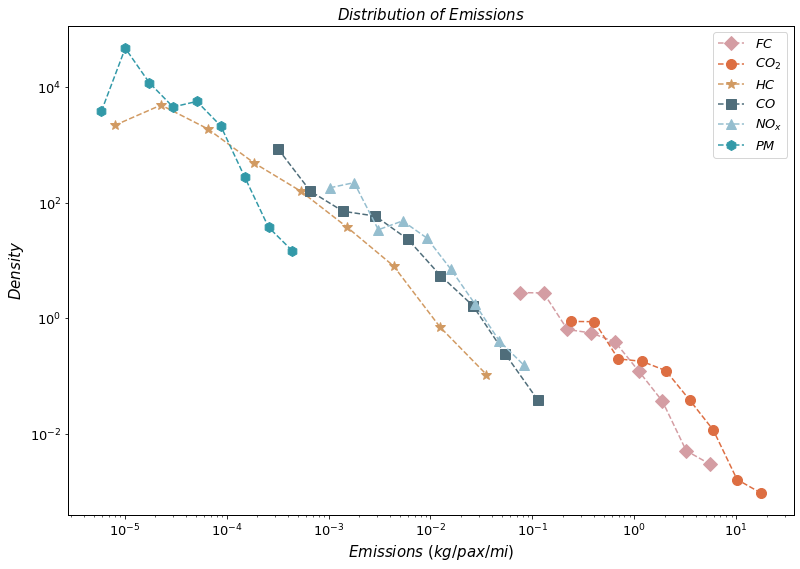

In [48]:
indices = ['Fuel Consumption (kg/pax/mi)', 'CO2 (kg/pax/mi)', 'HC (kg/pax/mi)', 'CO (kg/pax/mi)', 
           'NOx (kg/pax/mi)', 'PM (kg/pax/mi)']
color_palette = {'Fuel Consumption (kg/pax/mi)': '#d49da3', 'CO2 (kg/pax/mi)': '#DD6E42', 'HC (kg/pax/mi)': '#d19a62',  
                 'CO (kg/pax/mi)': '#4F6D7A', 'NOx (kg/pax/mi)': '#95becf', 
                 'PM (kg/pax/mi)': '#3299a8'}
marker_palette = {'Fuel Consumption (kg/pax/mi)': '--D','CO2 (kg/pax/mi)': '--o', 'HC (kg/pax/mi)': '--*', 
                  'CO (kg/pax/mi)': '--s', 'NOx (kg/pax/mi)': '--^', 'PM (kg/pax/mi)': '--h'}
label_palette = {'Fuel Consumption (kg/pax/mi)': '$FC$', 'CO2 (kg/pax/mi)': '$CO_{2}$', 
                 'HC (kg/pax/mi)': '$HC$', 'CO (kg/pax/mi)': '$CO$', 'NOx (kg/pax/mi)': '$NO_{x}$', 
                 'PM (kg/pax/mi)': '$PM$'}
fig, ax = plt.subplots(figsize = (13, 9))
    
for kk in indices:
    em = list(CA_flight_network_scaled_loc[kk])
    n_bins = 10

    logBins = np.logspace(np.log10(min(em)), np.log10(max(em)), num = n_bins)
    logBinDensity, binedges = np.histogram(em, bins = logBins, density = True)

    ax.loglog(logBins[:-1], logBinDensity, marker_palette[kk], markersize = 10, 
               color = color_palette[kk], label = label_palette[kk])

plt.legend(fontsize = 13);
plt.xticks(fontsize = 13);
plt.yticks(fontsize = 13);
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')
plt.xlabel('$Emissions~(kg/pax/mi)$', fontsize = 15);
plt.ylabel('$Density$', fontsize = 15);
plt.title('$Distribution~of~Emissions$', fontsize = 15)
ax.patch.set_edgecolor('black')  
ax.patch.set_linewidth('1')
plt.savefig('Article Figures/Final/emissions_dist.png', bbox_inches = 'tight', pad_inches = 0, dpi = 300)
plt.show()

In [54]:
CA_flight_network_scaled_loc['Fuel Consumption (kg/pax/mi)'].min()

0.07532380674203137

In [55]:
CA_flight_network_scaled_loc[CA_flight_network_scaled_loc['Num. of Flights'] < 50][['OD Pair Name', 'Pax', 'Num. of Flights']]



,OD Pair Name,Pax,Num. of Flights
2,APCBUR,8.538462,13
3,APCBUR,8.800000,20
4,APCLAS,10.045455,22
5,APCLAX,9.833333,18
6,APCLAX,11.465024,36
...,...,...,...
422,TOAVNY,8.000000,12
425,TUSVNY,8.851852,27
426,TUSVNY,9.137931,29
427,UDDVNY,8.600000,15


#### Writing Functions for Network Creation and Plotting:
1. Transforming coordinates from Latitude and Longitude to Decimal Degrees (for basemap plotting purposes)

In [56]:
import contextily as ctx
from pyproj import Transformer

TRAN_4326_TO_3857 = Transformer.from_crs("EPSG:4326", "EPSG:3857")

def transform_coordinates(loc_dict):
    transformed = {}
    for airport in loc_dict:
        transformed[airport] = TRAN_4326_TO_3857.transform(loc_dict[airport][1], loc_dict[airport][0])
    return transformed

2. Gathering Providers of Contextily Basemaps

In [57]:
providers = {}

def get_providers(provider):
    if "url" in provider:
        providers[provider['name']] = provider
    else:
        for prov in provider.values():
            get_providers(prov)

get_providers(ctx.providers)

3. Creating Network: Using networkx library to create network by adding edges, transforming data to have normal distribution for better visualization, plotting basemaps, plotting network nodes, edges, colorbar

In [74]:
def create_network(df, metric, colorbar = 0, upper = 0):
    #create location dictionary for latitude and longitude of airports
    lat_lon_dict = {}
    for ii in df.index.unique():
        lat_lon_dict[df.loc[ii]['Departure']] = (df.loc[ii]['Dep Lon'], df.loc[ii]['Dep Lat'])
        lat_lon_dict[df.loc[ii]['Arrival']] = (df.loc[ii]['Arr Lon'], df.loc[ii]['Arr Lat'])
        
    #transform location dictionary
    lat_lon_dict = transform_coordinates(lat_lon_dict)
    
    #create directed graph for OOC
    ca_network = nx.DiGraph()
    for jj in df.index:
        ca_network.add_edge(df.loc[jj]['Departure'], df.loc[jj]['Arrival'])
        
    edge_metric_dict = dict(zip(list(zip(list(df['Departure']), list(df['Arrival']))), list(df[metric])))
    weight_dict = dict(zip(list(zip(list(df['Departure']), list(df['Arrival']))), list(df['Num. of Flights'])))
    
    community_metric_dict = dict(zip(list(zip(list(df['Departure']), list(df['Arrival']))), df['CO2 Community']))
    nx.set_edge_attributes(ca_network, community_metric_dict, name = 'CO2 Community')
    
    #if creating the entire network (for analysis purposes, not graphing)
    if upper == 2:
        return ca_network, ca_network.to_undirected()
    
    edge_list = list(ca_network.edges())
    
    edge_metric_list = []
    for aa in edge_list:
        edge_metric_list.append(edge_metric_dict[aa])
        
    def colormap_assign(metric_array, cm_choice):
        norm_array = (metric_array - metric_array.min()) / (metric_array.max() - metric_array.min())
        color_array = cm_choice(norm_array)
        return list(color_array)
    
    #transform emissions to have normal distribution for easier visualization interpretation
    color_map_assigned = plt.cm.summer
    if upper == 1:
        color_map_assigned = plt.cm.autumn_r
    elif upper == 3:
        color_map_assigned = plt.cm.RdYlGn
        
    pt = sk.preprocessing.PowerTransformer(method = 'box-cox')
    pt.fit(np.array(edge_metric_list).reshape(-1,1))
    edge_metric_list = pt.transform(np.array(edge_metric_list).reshape(-1,1))
    edge_color_list = colormap_assign(edge_metric_list.flatten(), color_map_assigned)

    sns.set_style("whitegrid", {'axes.grid' : False})
    fig, ax = plt.subplots(figsize = (15, 17.25))
    
    edges = nx.draw_networkx_edges(ca_network, pos = lat_lon_dict, alpha = 0.8, edge_color = edge_color_list, 
                                   style = 'solid', connectionstyle="arc3,rad=0.2")
    
    nodes = nx.draw_networkx_nodes(ca_network, pos = lat_lon_dict, node_size = 150, node_color = '#ffd745', 
                                   alpha = 1, edgecolors = '#787777')
    #labels = nx.draw_networkx_labels(ca_network, pos = lat_lon_dict, font_size = 10)
   
    west, south, east, north = (-125.59624,
                                31.95,
                                -108.93022,
                                45.55)
    ca_region_img, ca_extent = ctx.bounds2img(west, south, east, north, ll=True,
                                             source = ctx.providers.CartoDB.VoyagerNoLabels)
    ax.imshow(ca_region_img, extent = ca_extent)
    if colorbar == 1:
        vmin = min(edge_metric_list); vmax = max(edge_metric_list)
        normalized = plt.Normalize(vmin = vmin, vmax = vmax)
        cmap = color_map_assigned
        sm = plt.cm.ScalarMappable(cmap = color_map_assigned, norm = normalized)
        sm.set_array([])
        cbar = plt.colorbar(sm)
        old_ticks = cbar.get_ticks()
        new_ticks = np.round(pt.inverse_transform(old_ticks.reshape(-1,1)).flatten(), 3)
        cbar.ax.set_yticklabels(new_ticks)
        cbar.set_label('$CO_{2}~(kg~per~pax-mile)$', rotation = 90, size = 15)

    #formatting plot
    plt.xticks([])
    plt.yticks([])
    
    #if saving:
    plt.savefig('Article Figures/Pre-Processed/regional_network_upper_cb.png', transparent = True, bbox_inches = 'tight', pad_inches = 0, dpi = 300)
    plt.show()
    return ca_network

4. Creating Legend: Legend for PM/NOx node sizes for visualization 

In [59]:
def create_legend(value_dict, emission, multiplier, color, edgecolor):
    new_nodes = nx.Graph()
    pos_dict = {}
    size_dict = {}
    values = list(value_dict.values())
    percentiles = np.array([np.percentile(values, 20), np.percentile(values, 40), np.percentile(values, 60),
                   np.percentile(values, 80), np.percentile(values, 100)]);
    i = 0
    for vv in value_dict:
        if value_dict[vv] in list(percentiles): 
            idx = np.where(percentiles == value_dict[vv])[0][0]
            new_nodes.add_node(idx)
            pos_dict[idx] = (0, 5-idx)
            size_dict[idx] = value_dict[vv]
            i += 1
    fig, ax = plt.subplots(frameon = False)
    ax.axis('off')
    nx.draw_networkx_nodes(new_nodes, pos = pos_dict, 
                           node_size = [s*multiplier for s in list(size_dict.values())],
                           node_color = color, edgecolors = edgecolor)
    for ii in range(0, 5):
        label = str(round(size_dict[ii], 3))
        plt.text(0.006, pos_dict[ii][1] - 0.08, label, fontsize = 12, fontweight = 'bold')
    #plt.savefig('Article Figures/Pre-Processed/nox_nodes_legend.png', transparent = True, bbox_inches = 'tight', pad_inches = 0, dpi = 300)
    plt.show()

In [96]:
def create_legend_2(value_dict, emission, multiplier, color, edgecolor):
    new_nodes = nx.Graph()
    pos_dict = {}; size_dict = {}
    values = list(value_dict.values())
    mi = min(values); ma = max(values)
    percentiles = np.array([np.percentile(values, 20), np.percentile(values, 100)])
    i = 0
    for vv in value_dict:
        if value_dict[vv] in list(percentiles):
            idx = np.where(percentiles == value_dict[vv])[0][0]
            new_nodes.add_node(idx)
            pos_dict[idx] = (i* 0.3, 0)
            size_dict[idx] = value_dict[vv]
            i += 1
    fig, ax = plt.subplots(frameon = False)
    ax.axis('off')
    nx.draw_networkx_nodes(new_nodes, pos = pos_dict,
                           node_size = [s * multiplier for s in list(size_dict.values())],
                           node_color = color, edgecolors = edgecolor, alpha = 0.7)
    for ii in range(0, 2):
        label = str("{:.2e}".format(size_dict[ii]))
        plt.text(pos_dict[ii][0] - 0.1, -0.02, label, fontsize = 15, fontweight = 'bold', color = 'black')
    ax.set_xlim([-0.05, 1])
    plt.savefig('Article Figures/Pre-Processed/pm_nodes_legend.png', transparent = True, bbox_inches = 'tight', pad_inches = 0, dpi = 300)
    plt.show()

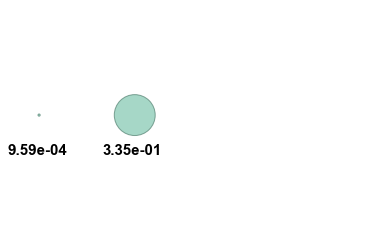

In [95]:
create_legend_2(nox_value_dict, 'NOx', 5e3, '#81c7b0', '#528070')

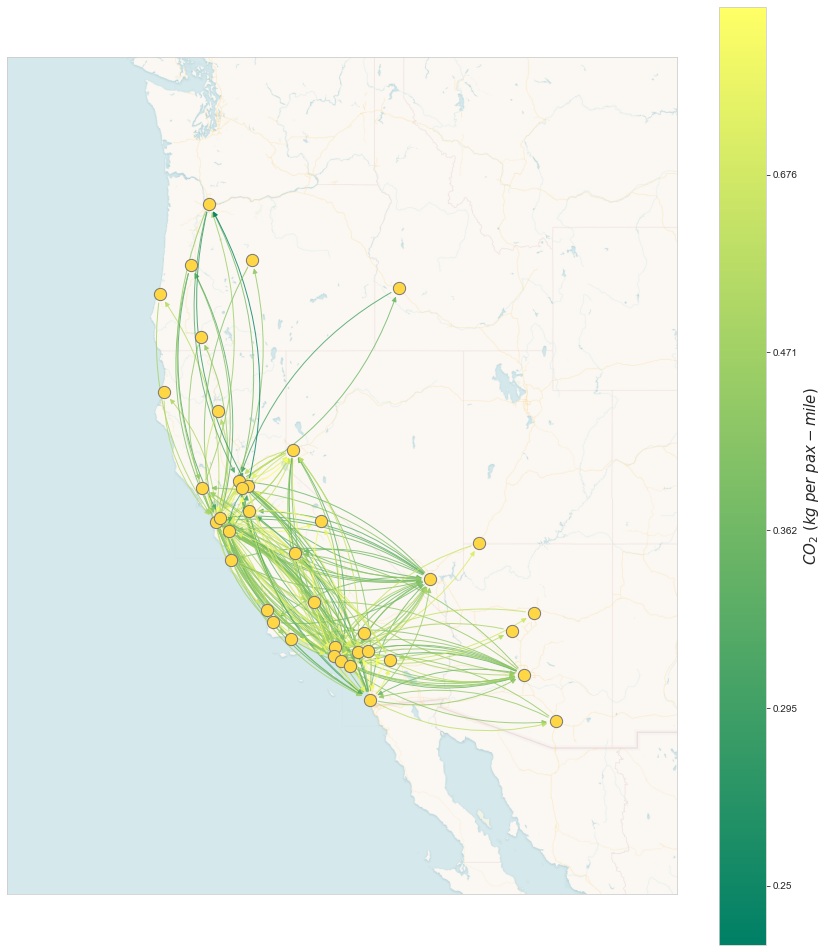

In [71]:
ca_networkx = create_network(lower, 'CO2 (kg/pax/mi)', colorbar = 1, upper = 0)

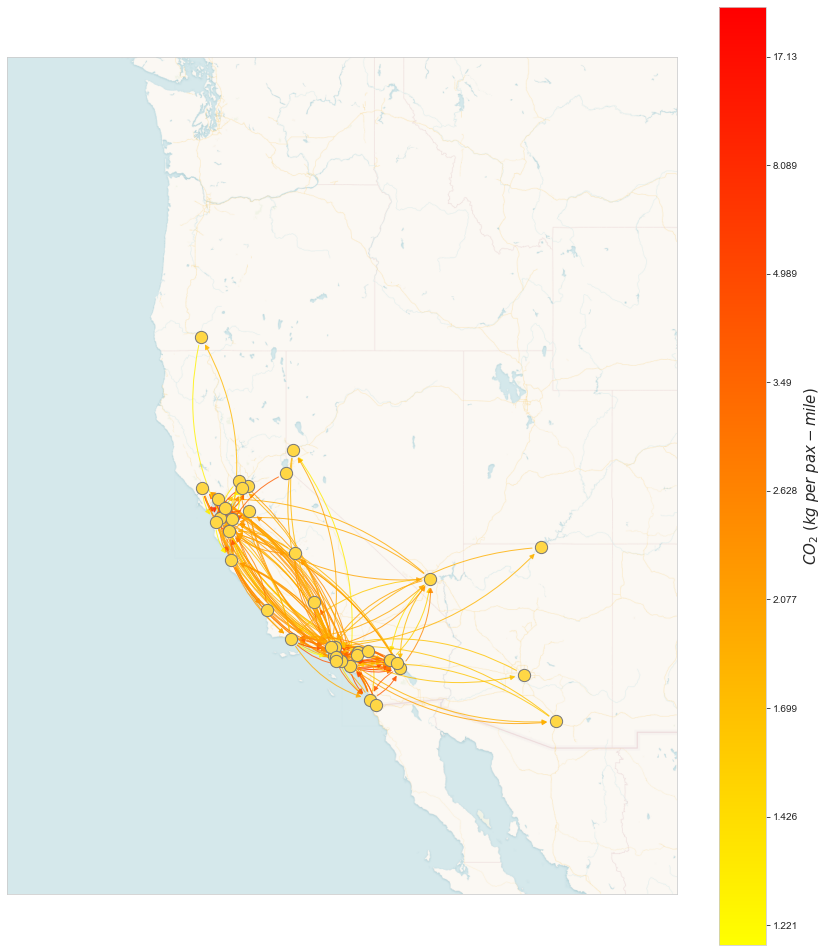

In [75]:
ca_networkx_upper = create_network(upper, 'CO2 (kg/pax/mi)', colorbar = 1, upper = 1)

# 4. Distribution of Node Linkages

In [76]:
from collections import Counter

def plot_degree_histogram(g, normalized = True, weight = None):
    
    degree_sequence = sorted([d for n, d in g.degree(weight = weight)], reverse=True)  # degree sequence
    degreeCount = Counter(degree_sequence)
    aux_x, aux_y = zip(*degreeCount.items())

    n_nodes = g.number_of_nodes()
    print(n_nodes)
    aux_y = list(aux_y)
    if normalized:
        for i in range(len(aux_y)):
            aux_y[i] = aux_y[i]/n_nodes
    
    return aux_x, aux_y

In [77]:
full_network_orig, full_network = create_network(CA_flight_network_scaled_loc, 'CO2 (kg/pax/mi)', colorbar = 0, upper = 2)
x,y = plot_degree_histogram(full_network, 'Flights')

51


In [78]:
from scipy.optimize import curve_fit
from scipy import optimize

def powlaw(x, a, b) :
    return a * np.power(x, b)

def log(x, a, b):
    return a + b*np.log(x)

def r_squared(x, y, f_name, popt):
    residuals = y - f_name(x, *popt)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y - np.mean(y))**2)
    r_squared = 1 - (ss_res / ss_tot)
    return r_squared

In [79]:
popt, pcov = curve_fit(powlaw, x, y)
aa, bb = popt


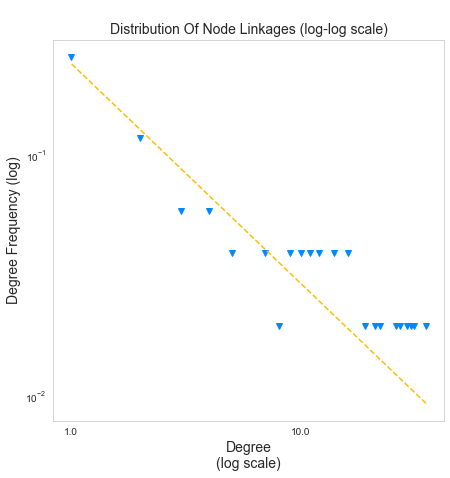

In [80]:
from matplotlib.ticker import FormatStrFormatter
import matplotlib as mb

fig, ax = plt.subplots(figsize = (7, 7))
plt.title('\nDistribution Of Node Linkages (log-log scale)', fontsize = 14)
plt.xlabel('Degree\n(log scale)', fontsize = 14)
plt.ylabel('Degree Frequency (log)', fontsize = 14)
plt.xscale('log')
plt.yscale("log")
ax.get_xaxis().set_major_formatter(mb.ticker.ScalarFormatter())
plt.plot(x, y, 'v', color = '#0388fc')
plt.plot(x, powlaw(x, aa, bb), '--', color = '#fcbe03')
#plt.text(19, 0.26, 'r-squared: ' + str(np.round(r_squared, 2)))
plt.show()

# 5. PM and NOx at Airports

In [81]:
airport_associated_emissions = airport_associated_emissions.merge(f, left_index = True, right_on = 'IATA').set_index('IATA').drop(['ICAO'], axis = 1)

pm_value_dict = airport_associated_emissions.loc[airport_associated_emissions.index, 'PM'].to_dict()
nox_value_dict = airport_associated_emissions.loc[airport_associated_emissions.index, 'NOx'].to_dict()

In [82]:
lat_lon_dict = {}
for k in airport_associated_emissions.index:
    lat_lon_dict[k] = (airport_associated_emissions.loc[k]['Longitude'], 
                       airport_associated_emissions.loc[k]['Latitude'])

In [83]:
PM_nodes = nx.Graph()
NOx_nodes = nx.Graph()
for ap in airport_associated_emissions.index:
    PM_nodes.add_node(ap)
    NOx_nodes.add_node(ap)


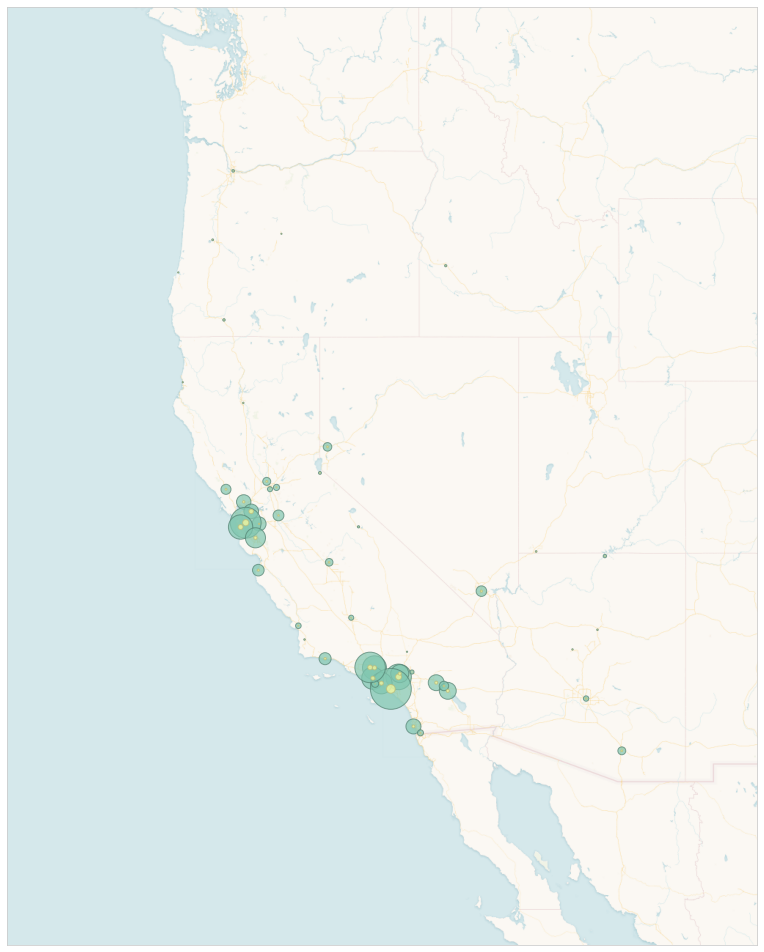

In [85]:
#visualize PM emissions at airports:

#1. plot PM pollutants
fig_PM, ax_PM = plt.subplots(figsize = (15, 17.25))

nx.draw_networkx_nodes(NOx_nodes, pos = transform_coordinates(lat_lon_dict), node_size = [s*5e3 for s in list(nox_value_dict.values())],
                       node_color = '#81c7b0', alpha = 0.7, edgecolors = '#528070')

nx.draw_networkx_nodes(PM_nodes, pos = transform_coordinates(lat_lon_dict), node_size = [s*1e5 for s in list(pm_value_dict.values())],
                       node_color = '#fffc9e', alpha = 0.7, edgecolors = '#bdbb77')
#nx.draw_networkx_labels(PM_nodes, pos = transform_coordinates(lat_lon_dict), font_size = 10)

# plot basemap
west, south, east, north = (-125.59624,
                            31.95,
                            -108.93022,
                            45.55)
ca_region_img, ca_extent = ctx.bounds2img(west, south, east, north, ll=True,
                                          source = ctx.providers.CartoDB.VoyagerNoLabels)
ax_PM.imshow(ca_region_img, extent = ca_extent)

plt.xticks([])
plt.yticks([])

plt.savefig('Article Figures/Pre-Processed/NOx_PM_nodes.png', transparent = True, bbox_inches = 'tight', pad_inches = 0, dpi = 300)
plt.show()

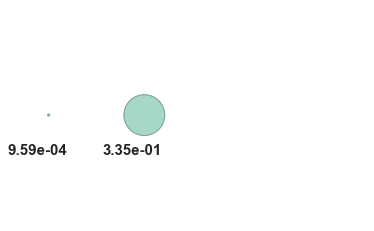

In [87]:
create_legend_2(nox_value_dict, 'NOx', 5e3, '#81c7b0', '#528070')

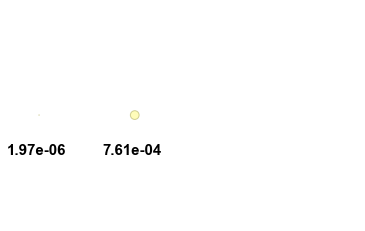

In [97]:
create_legend_2(pm_value_dict, 'PM', 1e5, '#fffc9e', '#bdbb77')

# 6. Network Analysis

In [ ]:
xx, ca_networkx = create_network(CA_flight_network_scaled_loc, 'CO2 (kg/pax/mi)', colorbar = 0, upper = 2)

In [ ]:
#checking for small-world properties
clustering = nx.average_clustering(ca_networkx)
avg_short_path = nx.average_shortest_path_length(ca_networkx)
length = len(ca_networkx.nodes())
average_degree = floor(np.mean(list(dict(ca_networkx.degree()).values())))

In [ ]:
scale_free = nx.barabasi_albert_graph(length, 8)

In [ ]:
random_graph = nx.watts_strogatz_graph(length, average_degree, 1, seed=None)
clustering_random = nx.average_clustering(random_graph)
avg_shortest_path_random = nx.average_shortest_path_length(random_graph)

In [ ]:
print('Clustering Coefficient for Regional Flight Network: ', round(clustering, 3))
print('Clustering Coefficient for Random Graph: ', round(clustering_random, 3))
print('Average Shortest Path for Regional Flight Network: ', round(avg_short_path, 3))
print('Average Shortest Path for Random Graph: ', round(avg_shortest_path_random, 3))

In [ ]:
deg_centrality = nx.degree_centrality(ca_networkx)
bet_centrality = nx.betweenness_centrality(ca_networkx)

In [ ]:
x = list(deg_centrality.values())
y = list(bet_centrality.values())
airport_labels = enumerate(list(deg_centrality.keys()))
s = np.multiply(x,y)*1e4
plt.figure(2, figsize=(15,10))
sns.scatterplot(x,y,s = s, color = '#91c3ff', edgecolor = 'black')
plt.xlabel('Degree Centrality', size = 12);
plt.ylabel('Betweenness Centrality', size = 12);
plt.title('Degree vs Betweenness Centrality for CA Regional Flight Network');
for i, name in airport_labels:
    if deg_centrality[name] > 0.4 or bet_centrality[name] > 0.02:
        plt.annotate(name, (x[i], y[i]), size = 13)
#plt.savefig('Article Figures/degree_between_graph.png', transparent = True, bbox_inches = 'tight', pad_inches = 0, dpi = 300)


# 7. Community Partition

In [ ]:
# community identification
def partition(network):
    partition = community.best_partition(network, weight = 'CO2 Community') #produces a frozen set, need to iterate through
    communities = []
    num_partitions = int(len(set(partition.values())))
    count = 0
    for i in set(partition.values()):
        count += 1
        list_nodes = [nodes for nodes in partition.keys() if partition[nodes] == i]
        communities.append(list_nodes)
        communities.sort(key = lambda x: len(x), reverse = True)
    return partition, communities

def color_community_partition(network, community_partition):
    airport_node_color = {}
    #pink, blue, red, orange, purple
    color_dict = {0: '#f280b7', 1: '#a9ceeb', 2: '#f7a043', 3: '#fa5252', 4: '#a091ff'}
    nodes = list(network.nodes())
    for airport in nodes:
        airport_node_color[airport] = color_dict[community_partition[airport]]
    color_list = list(airport_node_color.values())
    return color_list

In [ ]:
ca_network, ca_network_undirected = create_network(CA_flight_network_scaled_loc, 'CO2 (kg/pax/mi)', colorbar = 0, upper = 2)
x, y = partition(ca_network_undirected)
color_list_airports = color_community_partition(ca_network_undirected, x)

In [ ]:
nx.get_edge_attributes(ca_network_undirected, 'CO2 Community')

In [ ]:
departure_averages = CA_flight_network_scaled_loc.groupby('Departure').mean()['CO2 Community']
arrival_averages = CA_flight_network_scaled_loc.groupby('Arrival').mean()['CO2 Community']

missing_set = []

missing_arrival = set(departure_averages.index) - set(arrival_averages.index)
for mm in missing_arrival:
    arrival_averages = arrival_averages.append(pd.Series([0], index = [mm]))
    missing_set.append(mm)

missing_departure = set(arrival_averages.index) - set(departure_averages.index)
for nn in missing_departure:
    departure_averages = departure_averages.append(pd.Series([0], index = [nn]))
    missing_set.append(nn)

nodes_emissions = (arrival_averages + departure_averages) 
nodes_emissions = nodes_emissions.to_dict()

In [ ]:
node_sizes = []
for node in list(ca_network_undirected.nodes()):
    node_sizes.append(nodes_emissions[node])

In [ ]:
fig_com, ax_com = plt.subplots(figsize = (15, 17.25))

nodes = nx.draw_networkx_nodes(ca_network_undirected, pos = transform_coordinates(lat_lon_dict),
                               node_color = color_list_airports, alpha = 1, edgecolors = '#787777',
                               node_size = list(np.array(node_sizes) * 0.25))
edges = nx.draw_networkx_edges(ca_network, style = 'dashed', connectionstyle='arc3,rad=0.2', 
                               pos = transform_coordinates(lat_lon_dict), alpha = 0.1)

#labels = nx.draw_networkx_labels(ca_network_undirected, pos = transform_coordinates(lat_lon_dict), font_size = 8)

west, south, east, north = (-125.59624,
                            31.95,
                            -108.93022,
                            45.55)
ca_region_img, ca_extent = ctx.bounds2img(west, south, east, north, ll=True,
                                          source = ctx.providers.CartoDB.VoyagerNoLabels)
ax_com.imshow(ca_region_img, extent = ca_extent)

plt.xticks([])
plt.yticks([])

plt.savefig('Article Figures/Pre-Processed/airport_communities.png', transparent = True, bbox_inches = 'tight', pad_inches = 0, dpi = 300)
plt.show()

In [ ]:
y

In [ ]:
first_subgraph = ca_network_undirected.subgraph(y[0])
second_subgraph = ca_network_undirected.subgraph(y[1])
#third_subgraph = ca_network_undirected.subgraph(y[2])

In [ ]:
def remove_values_from_list(the_list, val):
    return [value for value in the_list if value != val]

graph0 = list(nx.get_edge_attributes(first_subgraph, 'CO2 Community').values())
graph1 = list(nx.get_edge_attributes(second_subgraph, 'CO2 Community').values())

graph0 = remove_values_from_list(graph0, 0)
graph1 = remove_values_from_list(graph1, 0)

n_bins = 10

fig, ax = plt.subplots(figsize = (12, 9))

logBins0 = np.logspace(np.log10(min(graph0)), np.log10(max(graph0)), num = n_bins)
logBinDensity0, binedges0 = np.histogram(graph0, bins = logBins0, density = True)

logBins1 = np.logspace(np.log10(min(graph1)), np.log10(max(graph1)), num = n_bins)
logBinDensity1, binedges1 = np.histogram(graph1, bins = logBins1, density = True)

ax.loglog(logBins0[:-1], logBinDensity0,'--o', markersize = 10, color = '#f280b7', label = r'$degree\,(k)$')
ax.loglog(logBins1[:-1], logBinDensity1,'--*', markersize = 10, color = '#a9ceeb', label = r'$degree\,(k)$')

plt.ylabel('$P(s)$', fontsize = 15)
plt.xlabel('$Weighted\,Degree\,(s)$', fontsize = 15)
plt.legend(['Community 1', 'Community 2'])
plt.savefig('Article Figures/airport_communities_dist.png', transparent = True, bbox_inches = 'tight', pad_inches = 0, dpi = 300)
plt.show()

# 8. Network Graph (Eviation Alice)

In [ ]:
subset = pd.read_csv('eviation_alice_subset.csv').drop(['Unnamed: 0'], axis = 1)
subset

In [ ]:
subset_network = create_network(subset, 'Alice Emissions', colorbar = 1, upper = 3)